## Convert GIS shape files into xarray masks

In [1]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import sys
from matplotlib import path
import shapefile
import geopandas as gpd
from shapely.geometry import Polygon
import pyproj
from shapely.geometry import Point
import matplotlib.path as mpltPath
from shapely.geometry.multipolygon import MultiPolygon


In [2]:
dir_figs = './figures/'
dir_shp = './data/LME/'
data_dir = './data/'

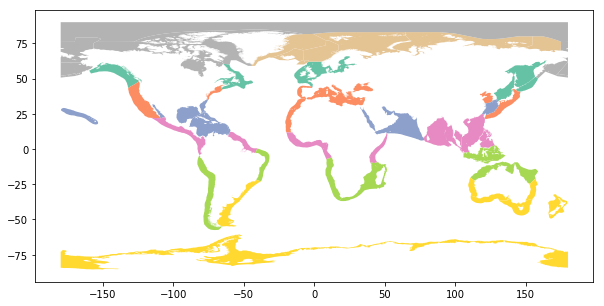

In [3]:
shp_file_base = 'LME66.shp'
df = gpd.read_file(dir_shp+shp_file_base)
crs_source = ('+proj=natearth +ellps=GRS80 +unit=m +lon_0=180')
df.crs = crs_source  
df.plot(cmap='Set2', figsize=(10, 10),vmin=0,vmax=100);


# Read in ERSST data

In [4]:
url = 'https://podaac-opendap.jpl.nasa.gov:443/opendap/allData/ersst/L4/ncei/v3b/monthly/netcdf/2016/ersst.201602.nc'
ds = xr.open_dataset(url)
ds = ds.isel(lev=0).isel(time=0)
ds.coords['lon'] = (ds.coords['lon'] + 180) % 360 - 180
ds = ds.sortby('lon').sortby('lat')


# Plot SST as background for all LMEs
- Use cartopy to put in coastlines

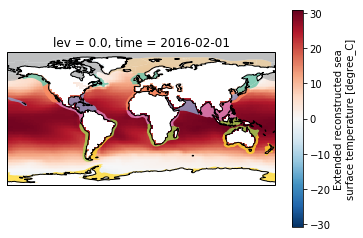

In [5]:
ax = plt.axes(projection=ccrs.PlateCarree())
df.plot(ax=ax,cmap='Set2',vmin=0,vmax=100,alpha=.8);
ds.sst.plot(ax=ax,zorder=-1)
ax.coastlines()

## Use the 66_LME file to create one mask 

the mask contains integers signifying which LME the area pertains to 

individual masks can be created, but this line is commented out currently

* warning: this code takes a while to go through all 66 masks

In [29]:
#process 66_LME file into individual masks and one mask with all values.
dir_figs = './figures/'
dir_shp = './data/LME/'
data_dir = './data/'

lats,lons=np.arange(-90,90,.1),np.arange(-180,180,.1)
shp_file_base = 'LME66.shp'


#create 2d grid from lats and lons
[lon2d,lat2d]=np.meshgrid(lons,lats)

#create a list of coordinates of all points within grid
points=[]
for latit in range(0,lats.size):
    for lonit in range(0,lons.size):
        point=(lon2d[latit,lonit],lat2d[latit,lonit])
        points.append(point)

#turn into np array for later
points=np.array(points)

df = gpd.read_file(data_dir+shp_file_base)
crs_source = ('+proj=natearth +ellps=GRS80 +unit=m +lon_0=180')
df.crs = crs_source  

indf = df.copy(deep=True)
outdf = gpd.GeoDataFrame(columns=indf.columns)
mask_all=np.zeros_like(lon2d)
init_data=0
sv_names=np.empty(67).astype('str')
for iob in range(1,67):
    mask=np.zeros_like(lon2d)

    subset = df.loc[df['OBJECTID']==iob]
    name_region = subset['LME_NAME'][iob-1].replace(" ", "_")
    num_region = subset['LME_NUMBER'][iob-1].astype('int')
    mask_region=np.ones_like(lon2d)*num_region

    if 'Multi' not in str(subset.geometry.type):
        #this code is modified from https://polarwatch.noaa.gov/tools-training/code-gallery/basic-polygon-access-visualization
        polyListx, polyListy = subset.exterior[iob-1].xy          # perimeter of polygon
        polyList = list(zip(list(polyListx),list(polyListy))) # formatted perimeter
        p = path.Path(polyList)                               # path for mask
        X, Y = np.meshgrid(lons, lats)                        # create the grid
        points = np.array((X.flatten(), Y.flatten())).T       # break it down
        mask = p.contains_points(points).reshape(X.shape)     # calc and grid a mask based on polygon
        mask_all = np.ma.where(mask, mask_region, mask_all)
        # polarwatch code end
    else:
        Edf2=subset.explode()
        for index,row in Edf2.iterrows():
            mypolygon=[]
            for pt in list(row['geometry'].exterior.coords):
                mypolygon.append(pt)
            path=mpltPath.Path(mypolygon)
            inside=path.contains_points(points)
            inside=np.array(inside).reshape(lon2d.shape)
            i=np.where(inside == True)
            mask[i]=num_region
            mask_all[i]=num_region
    
    ds_mask_tem=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask) },coords={'lat':lats,'lon':lons})
    ds_mask_tem['region_mask'].attrs['LME_name'] = name_region
    mask_name = str(num_region)+'_mask'
#    filename_out = data_dir+mask_name+'_mask.nc'
#    ds_mask_tem.to_netcdf(filename_out)
    sv_names[num_region]=name_region
ds_mask=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask_all),'LME_names':(('region'),sv_names )},coords={'lat':lats,'lon':lons,'region':np.arange(1,68,1)})
filename_out = data_dir+'LME_all_mask.nc'
ds_mask.to_netcdf(filename_out)
    

DriverError: ./data/LME66.shp: No such file or directory

In [ ]:
filename_out = data_dir+'LME_all_mask.nc'
ds_mask=xr.open_dataset(filename_out)
ds_mask.close()
ds_mask2 = ds_mask.where(ds_mask!=0,np.nan)
#import cartopy.crs as ccrs
#from cartopy.examples.arrows import sample_data
plt.figure(figsize=(13,6.2))
ax = plt.subplot(111, projection=ccrs.PlateCarree(central_longitude=180))#, 
#                                               min_latitude=-80, max_latitude=80))
ax.background_img(name='ne_shaded', resolution='low')
#ax.background_img(name='BM', resolution='high')
ax.set_extent([1,-1,-80,80])
mm = ax.pcolormesh(ds_mask.lon,\
                   ds_mask.lat,\
                   ds_mask2.region_mask,vmin=11, vmax=24, transform=ccrs.PlateCarree(),cmap='jet' )
ax.coastlines(resolution='10m');
plt.title('LME regions')
plt.colorbar(mm,ax=ax,shrink=.7,pad=.01,label='LME region number')
plt.savefig(dir_figs+'/LME_all_regions_mask_be.png', dpi=100)


In [24]:
#process PICES file into individual masks and one mask with all values.
#some are in lat/lon and some are in coordinate reference frame so I had to add a check for that

dir_shp = './data/PICES/'
data_dir = './data/'
data_fig = './figures/'

lats,lons=np.arange(-90,90,.1),np.arange(-180,180,.1)
#shp_file_base = 'PICES_NPESR_Region_12.shp'


#create 2d grid from lats and lons
[lon2d,lat2d]=np.meshgrid(lons,lats)

#create a list of coordinates of all points within grid
points=[]
for latit in range(0,lats.size):
    for lonit in range(0,lons.size):
        point=(lon2d[latit,lonit],lat2d[latit,lonit])
        points.append(point)

#turn into np array for later
points=np.array(points)

#there are some masks that wrap 180 which causes problems for the 'find inside'
#for these there is a cheat below, instead of +lon_0=180
#I put in +lon_0=0, create the mask then shift it to the-180,180 mask and save
mask_all=np.zeros_like(lon2d)

for root, dirs, files in os.walk(dir_shp, topdown=False):
    if root[len(dir_shp):len(dir_shp)+1]=='.':
        continue
    for name in files:
        if not name.endswith('.shp'):
            continue
        filename=os.path.join(root, name)
        print(name[:-4])
        name_region = name[:-4]
        num_region = int(name[-6:-4])
        df = gpd.read_file(filename)
        if ((num_region == 13) | (num_region==14) | (num_region==23) | (num_region==24) | (num_region==15)):
            crs_source = ('+proj=natearth +ellps=GRS80 +unit=m +lon_0=0')
            iwrap=1
        else:
            crs_source = ('+proj=natearth +ellps=GRS80 +unit=m +lon_0=180')
            iwrap=0
        df.crs = crs_source  
#check if in ITM or geocoordinates
        Edf2=df.explode() #explode_polygon(df)
        for index,row in Edf2.iterrows():
            mypolygon=[]
            for pt in list(row['geometry'].exterior.coords):
                mypolygon.append(pt)
        if (pt[0]>-180) & (pt[0]<180):
            df2 = df.copy(deep=True)
            print('nope: dont change coordinates')
        else:
            df2 = df.to_crs(epsg=4326) 
            print('yup, change coordinates')  
        
        init_data=0
        mask=np.zeros_like(lon2d)
        Edf2=df2.explode() #explode_polygon(df2)

        for index,row in Edf2.iterrows():
            #print('working on polygon', index)
            mypolygon=[]
            for pt in list(row['geometry'].exterior.coords):
                mypolygon.append(pt)
            path=mpltPath.Path(mypolygon)
            inside=path.contains_points(points)
            #find the results in the array that were inside the polygon ('True')
            #and set them to missing. First, must reshape the result of the search
            #('points') so that it matches the mask & original data
            #reshape the result to the main grid array
            inside=np.array(inside).reshape(lon2d.shape)
            i=np.where(inside == True)
            mask[i]=1
        if (iwrap==1):
            mask2=np.zeros(mask.shape)
            mask2[:,1:1800]=mask[:,1801:3600]#,mask[:,1:1800]]
            mask2[:,1800:3600]=mask[:,1:1801]
        else:
            mask2=mask
        if (num_region==15):
            mask2=mask
            
        mask_all= np.where(mask2==1,num_region,mask_all)
    ds_mask_tem=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask2) },coords={'lat':lats,'lon':lons})
    ds_masked = ds_mask_tem.where(ds_mask_tem['region_mask'] != 0)  
    min_lat,max_lat = lat2d[np.isfinite(ds_masked.region_mask)].min(),lat2d[np.isfinite(ds_masked.region_mask)].max()
    min_lon,max_lon = lon2d[np.isfinite(ds_masked.region_mask)].min(),lon2d[np.isfinite(ds_masked.region_mask)].max()
    ds_mask_tem['region_mask'].attrs['PICES_name'] = name_region
    ds_mask_tem['region_mask'].attrs['min_lon'] = min_lon
    ds_mask_tem['region_mask'].attrs['max_lon'] = max_lon
    ds_mask_tem['region_mask'].attrs['min_lat'] = min_lat
    ds_mask_tem['region_mask'].attrs['max_lat'] = max_lat
    mask_name = str(num_region)
    filename_out = data_dir+mask_name+'_mask.nc'
#    ds_mask_tem.to_netcdf(filename_out)
ds_mask_tem=xr.Dataset(data_vars={'region_mask': (('lat','lon'),mask_all) },coords={'lat':lats,'lon':lons})
ds_masked = ds_mask_tem.where(ds_mask_tem['region_mask'] != 0)  
min_lat,max_lat = lat2d[np.isfinite(ds_masked.region_mask)].min(),lat2d[np.isfinite(ds_masked.region_mask)].max()
min_lon,max_lon = lon2d[np.isfinite(ds_masked.region_mask)].min(),lon2d[np.isfinite(ds_masked.region_mask)].max()
ds_mask_tem['region_mask'].attrs['PICES_name'] = 'all'
ds_mask_tem['region_mask'].attrs['min_lon'] = min_lon
ds_mask_tem['region_mask'].attrs['max_lon'] = max_lon
ds_mask_tem['region_mask'].attrs['min_lat'] = min_lat
ds_mask_tem['region_mask'].attrs['max_lat'] = max_lat
mask_name = 'PICES_all'
filename_out = data_dir+mask_name+'_mask.nc'
ds_mask_tem.to_netcdf(filename_out)
            
    

PICES_NPESR_Region_11
yup, change coordinates
PICES_NPESR_Region_12
nope: dont change coordinates
PICES_NPESR_Region_13
yup, change coordinates
PICES_NPESR_Region_14
yup, change coordinates
PICES_NPESR_Region_15
nope: dont change coordinates
PICES_NPESR_Region_16
yup, change coordinates
PICES_NPESR_Region_17
yup, change coordinates
PICES_NPESR_Region_18
yup, change coordinates
PICES_NPESR_Region_19
yup, change coordinates
PICES_NPESR_Region_20
yup, change coordinates
PICES_NPESR_Region_21
yup, change coordinates
PICES_NPESR_Region_22
yup, change coordinates
PICES_NPESR_Region_23
yup, change coordinates
PICES_NPESR_Region_24
yup, change coordinates


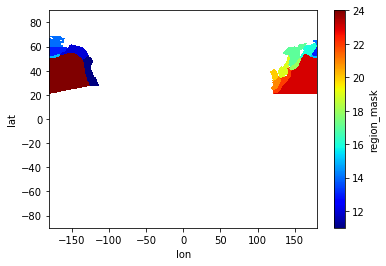

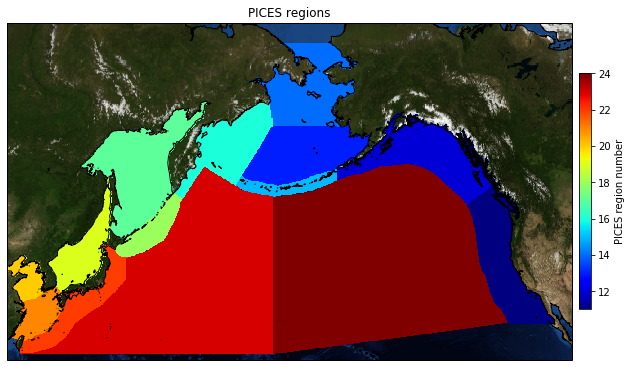

In [28]:
import cartopy.crs as ccrs
from cartopy.examples.arrows import sample_data
ds_mask_tem2 = ds_mask_tem.where(ds_mask_tem>0,np.nan)
ds_mask_tem2.region_mask.plot(cmap='jet',vmin=11,vmax=24)
plt.figure(figsize=(13,6.2))
ax = plt.subplot(111, projection=ccrs.Mercator(central_longitude=180, 
                                               min_latitude=20, max_latitude=70))
#ax.background_img(name='ne_shaded', resolution='low')
ax.background_img(name='BM', resolution='high')
ax.set_extent([118,-110,20,70])
mm = ax.pcolormesh(ds_mask_tem2.lon,\
                   ds_mask_tem2.lat,\
                   ds_mask_tem2.region_mask,vmin=11, vmax=24, transform=ccrs.PlateCarree(),cmap='jet' )
ax.coastlines(resolution='10m');
plt.title('PICES regions')
plt.colorbar(mm,ax=ax,shrink=.7,pad=.01,label='PICES region number')
plt.savefig('./figures/PICES_all_regions_mask_be.png', dpi=100)


In [ ]:
#example on how to mask data for just one region
filename = './data/PICES_all_mask.nc'
ds_pices = xr.open_dataset(filename)
ds_pices.close()
ds_mask = ds_pices.where(ds_pices==15,np.nan)
ds_mask.region_mask.plot(cmap='jet',vmin=11,vmax=24)